# ML - 03. Decision Tree

### 특징
- 설명하기가 아주 편하고 직관적이다.
- 크기가 커지면 오버피팅이 심할 수 있다. (bias가 크다.)
- 실질적으로 성능이 아주 좋지가 않아서, 일반적으로 잘 사용은 하지 않는다.
- 다만, 요즘 단순 Decision Tree를 사용하지 않고, Random Forest나 다른 방식의 Tree를 많이 사용한다.
- 예전에는 일단 Random Forest에 넣어서 확인을 하고 사용했다면, 요즘은 Random Forest나 Xgboost를 RF대용으로 더 많이 사용하고 있다.

## 참고 : Scikit-Learn의 preprocessing  관련 사항  
* 스케일링[scaling] : 자료 크기 조정  
(목적 : overflow, underflow 를 방지하고, 독립변수의 공분산 행렬의 조건수(condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴속도 향상)
scale - StandardScaler[표준정상분포 Standard Normal Gaussian 기본 스케일]  
normalize - Normalizer  
minmax_scale - MinMaxScaler[최대/최소값 사용]  
maxabs_scale - MaxAbsScaler[최대절대값 사용]  
robust_scale - RobustScaler[median, interquartile range 사용. outlier 영향 최소화]  

* 인코딩[Encoding]: 카테고리 값의 정수 표현  
(인코딩 : 카테고리 값이나 텍스트 정보를 처리할 수 있는 정수로 변환하는 프로세스)  
binarize - Binarizer[th 값을 기준으로 0/1로 처리하는 것]  
label_binarize - LabelBinarizer[onehot과 유사하지만, 사용되는 카테고리만 사용하여 컬럼으로 ]  
LabelEncoder[k 개의 종류가 있다면 0~k-1까지의 정수로 단순히 변경해서 수행]  
OneHotEncoder[k개의 값을 가지는 스칼라 값을 0또는 1의 값을 가지는 k차원의 벡터로 변환]  
DictVectorizer[주로 텍스트에서 원드별로 카운트와 관련된 것 처리할 때]  

* Imputation: 결손 데이터(missing data) 처리  
Imputer

* Transform: 데이터 변환 
PolynomialFeatures[x를 1, x, x^2, x^3 ..등으로 표현하는 것]  
FunctionTransformer[Transform으로 f함수 통해서 변형]

* 참고 : One-Hot-Encoder[번주형 변수 처리하는데 많이 사용되는 방법 중 하나]  
범주형 변수로 성별으로 남/여 처럼 되어 있으면 2가지로 코딩이 되는데, 이 보다 많은 종류를 가지게 되는 경우에는 어떻게 할것인가 문제가 된다.  
등급을 10등급으로 한다고 하면, 실제 트리상에서는 2^10으로 1024가지의 경우를 판단해야 한다.  
그래서 거의 32개로 되어 있으면, 그 양만해도 2^32으로 심각하게 오버로딩이 많이 걸리게 된다. 
그래서 거의 dummy variable encoding 방식이라고 이해하면 됨.  
아래 그림을 보면 제일 확실히 이해가 됨!  

## data: hitters.csv (야구 선수 급여)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn import metrics

%matplotlib inline

In [57]:
Hitters = pd.read_csv("../data/01_hitters/Hitters.csv")

In [58]:
Hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


### 데이터 처리
- salary의 갑시 없는 obs제거
- Unnamed:0 칼럼 이름 변경 & - 제거
- 결과 변수 salary의 log변환

In [59]:
Hitters.dropna(inplace=True)
Hitters.shape

(263, 21)

In [60]:
Hitters.rename(columns = {'Unnamed: 0' : 'Name'}, inplace = True)

In [61]:
Hitters['Name'] = Hitters['Name'].map(lambda x: x.replace("-",""))
Hitters.head()

,Name,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


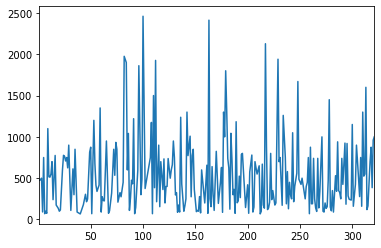

In [62]:
Hitters.Salary.plot()

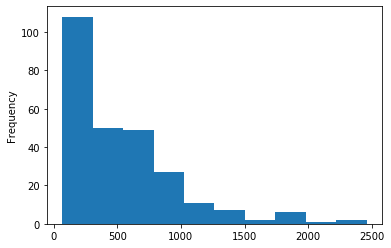

In [63]:
Hitters.Salary.plot(kind="hist")

In [64]:
# log 변경
# 한쪽에 치우친 부분을 펴는 작업
Hitters['Salary'] = np.log(Hitters.Salary)

### 변동폭이 확연히 줄었다.

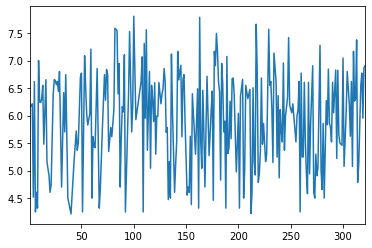

In [65]:
Hitters.Salary.plot()

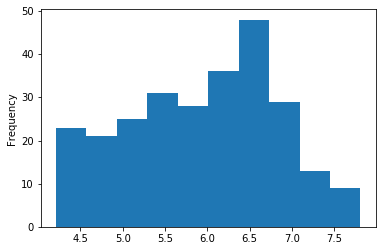

In [66]:
Hitters.Salary.plot(kind="hist")

In [67]:
# reindex
Hitters.dropna(inplace=True)
Hitters.reset_index(drop=True)
Hitters.head()

,Name,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,6.163315,N
2,Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,6.173786,A
3,Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,6.214608,N
4,Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,4.516339,N
5,Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,6.620073,A


In [68]:
Hitters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Name         263 non-null object
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 45.2+ KB


In [69]:
X = Hitters.loc[:,['Years','Hits']]
y = Hitters.Salary

# 너무 잘게잘게 쪼개지는 것(overfitting)을 방지하고자 제한을 걸어둠
reg_tree = tree.DecisionTreeRegressor(max_leaf_nodes=3)
reg_tree.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=3, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Text(13, 180, 'R3')

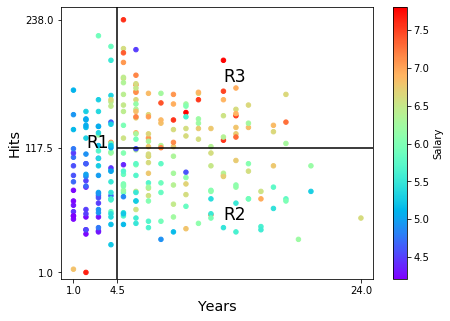

In [70]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))          

Hitters.plot('Years','Hits', kind='scatter',c = 'Salary',
             ax=ax1, xticks=[1, 4.5, 24], yticks=[1, 117.5, 238], 
             xlim=[0, 25], ylim=[-5, 250], cmap='rainbow') 

plt.xlabel('Years', fontsize='x-large')
plt.ylabel('Hits', fontsize='x-large')
plt.vlines(4.5,  ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize=17)
plt.annotate('R2', xy=(13,50), fontsize=17)
plt.annotate('R3', xy=(13,180), fontsize=17)

In [71]:
reg_tree.tree_.threshold

array([  4.5,  -2. , 117.5,  -2. ,  -2. ])

### graphviz

In [55]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

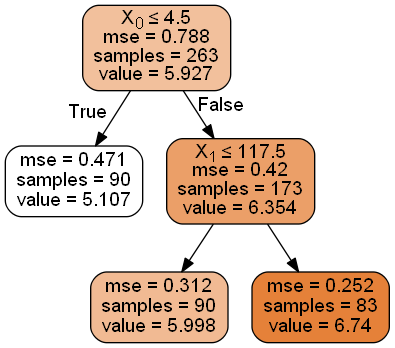

In [56]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(reg_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

- samples: 해당 노드에 속한 sample들의 개수
- value: 해당 노드에 속한 sample들의 mean response(reponse 평균)
- mse: sample들의 실제 response와 'value'간의 Mean Squared Error

In [74]:
Hitters.shape

(263, 21)

In [75]:
# Hitters 데이터 중에 qualitative 변수가 있으므로 이를
# dummy encoding & 'Name' column을 제거 (one hot encoding)
Hitters_enc = pd.get_dummies(Hitters.drop('Name',axis=1), drop_first=True)

# 모든 observation 활용
X = Hitters_enc.drop('Salary', axis=1)
y = Hitters_enc.Salary

# 최대 12단계로
reg_tree =tree.DecisionTreeRegressor(max_leaf_nodes=12)
reg_tree.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=12, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

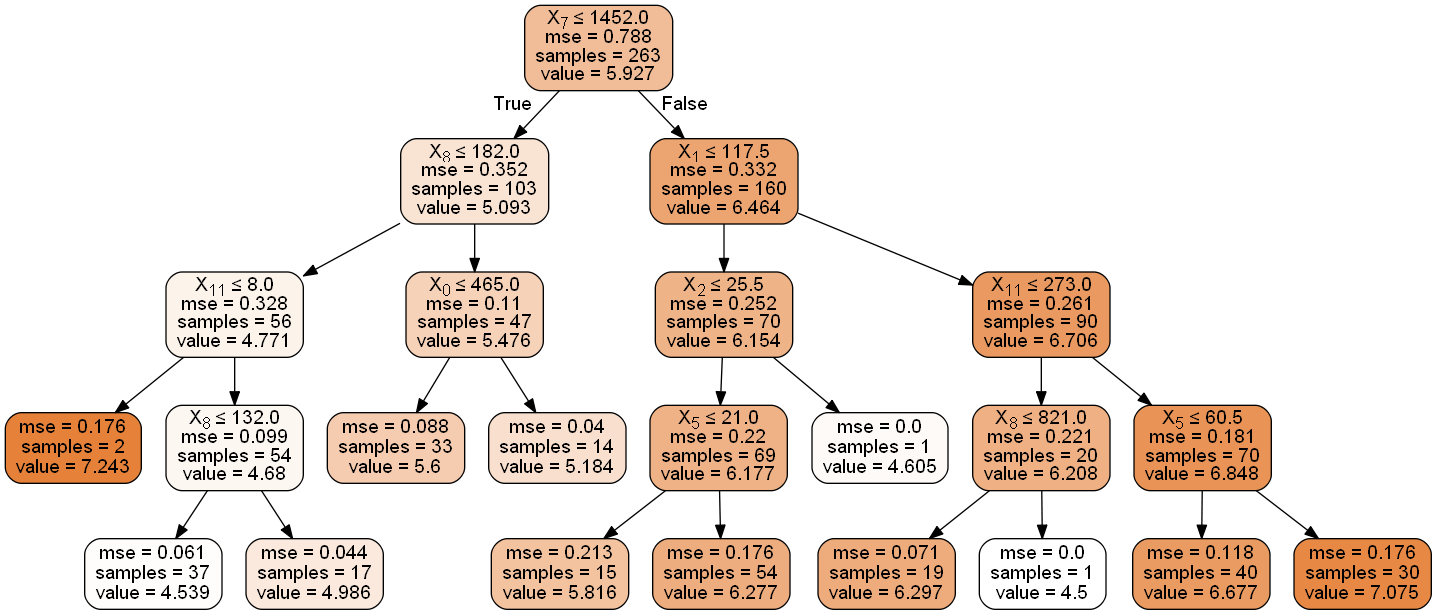

In [76]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(reg_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [77]:
Hitters_enc.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,6.163315,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,6.173786,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,6.214608,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,4.516339,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,6.620073,0,1,0


In [81]:
reg_tree.tree_.threshold

array([1452. ,  182. ,  117.5,    8. ,  465. ,   -2. ,  132. ,   25.5,
        273. ,  821. ,   60.5,   -2. ,   -2. ,   -2. ,   -2. ,   21. ,
         -2. ,   -2. ,   -2. ,   -2. ,   -2. ,   -2. ,   -2. ])

In [82]:
from sklearn.model_selection import cross_val_score

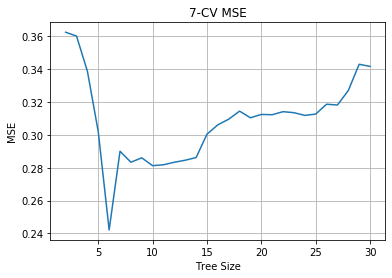

In [85]:
tree_sizes = range(2, 31)
MSE_scores = []
# 7로 , 7-fold
for size in tree_sizes:
    reg_tree = tree.DecisionTreeRegressor(max_leaf_nodes=size, random_state=123)
    # return을 negative로 주기 때문에 부호 변환(-)
    MSE_s = -cross_val_score(reg_tree, X, y, cv =7, scoring='neg_mean_squared_error')
    MSE_scores.append(np.mean(MSE_s))
    
    # plot CV-MSE as tree size gets bigger
plt.plot(tree_sizes, MSE_scores)
plt.title("7-CV MSE")
plt.xlabel("Tree Size")
plt.ylabel("MSE")
plt.grid(True)

### 6개로 하면 제일 좋은 성능이 나옴을 알 수 있다.
max_leaf_nodes는 쪼개지는 기준이되는 node가 몇 개인지 설정

In [86]:
reg_tree_best = tree.DecisionTreeRegressor(max_leaf_nodes=6, random_state=1234)
reg_tree_best.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=6, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1234, splitter='best')

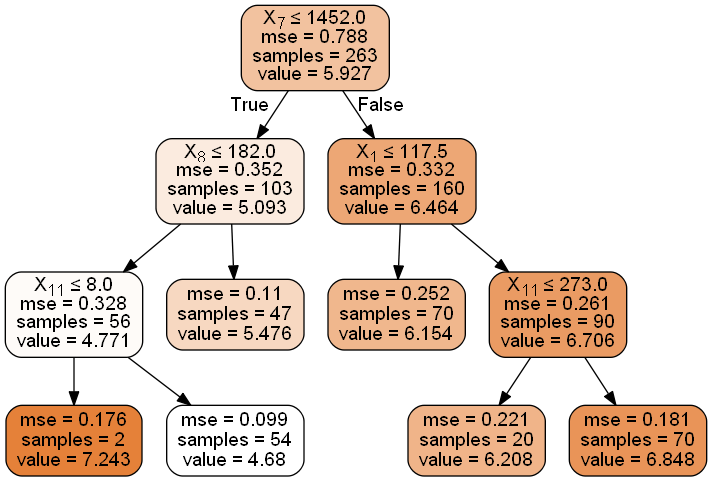

In [88]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(reg_tree_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [89]:
# 위의 그림이 안 보이기 때문에... 중요도를 기준으로 내림차순
feature_importance = pd.DataFrame({'feature':X.columns,
                                  'importance':reg_tree_best.feature_importances_})

feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
7,CAtBat,0.729415
11,CRBI,0.117926
8,CHits,0.078575
1,Hits,0.074083
0,AtBat,0.000000
17,Division_W,0.000000
16,League_N,0.000000
15,Errors,0.000000
14,Assists,0.000000
13,PutOuts,0.000000


- scikit-learn은 pruning을 제공하지 않는다. (가지치기)
- 그러나, 위에서 보았듯이 'terminal node의 수'에 따른 Cross-Validation과 같은 방법을 이용해서 Pruning과 비슷한 효과를 볼 수 있다.
- 그러나 RF와 Boosting은 Pruning을 사용한 어떤 단일 tree보다 나은거 같아서인지 업데이트를 잘 안한다.